# Machine Learning Test

### MSP 4.19.2018



In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests




In [3]:
#0: W
#1: IP
#2: GS
#3: TBF
#4: SO
#5: BB
#6: HR
#7: L

def scrape_saves(year='2018'):

    get_url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=0&season='+year+'&month=0&season1='+year+'&ind=0&team=0&rost=0&age=0&filter=&players=0&page=1_1000'
    r  = requests.get(get_url)

    data = r.text

    soup = BeautifulSoup(data)

    tables = soup.findAll('table')

    PDict = {}


    for row in tables[11].find_all("tr")[3:]: 
                #print(tnum)
                try:
                    #sav = [td.find('a') for td in row.find_all("td")][0]
                    sav = [td.get_text() for td in row.find_all("td")]
                    #print(sav)
                    PDict[sav[1]] = [float(sav[3]),float(sav[13]),float(sav[7]),float(sav[14]),float(sav[24]),float(sav[19]),float(sav[18]),float(sav[4])]
                except:
                    print('FAILED')

    return PDict



[0.0, 220.0, 0.5, 35.0]

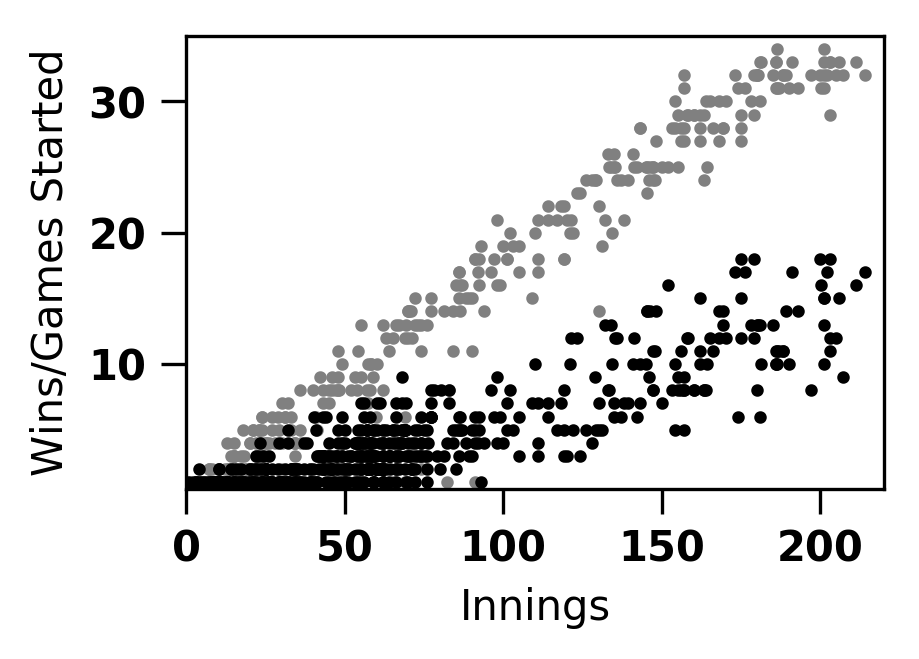

In [206]:
PDict = scrape_saves(year='2017')

plt.figure(figsize=(3,2))
plt.scatter(np.array(PDict.values())[:,1],np.array(PDict.values())[:,2],color='gray',s=4.)
plt.scatter(np.array(PDict.values())[:,1],np.array(PDict.values())[:,0],color='black',s=4.)

plt.xlabel('Innings')
plt.ylabel('Wins/Games Started')
plt.axis([0.,220.,0.5,35.])

Available columns:
0. W
1. IP
2. GS
3. TBF
4. SO
5. BB
6. HR
7. L





In [207]:
import tensorflow as tf

## Example 1
https://www.kaggle.com/autuanliuyc/logistic-regression-with-tensorflow

In [208]:
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)


PDict = scrape_saves(year='2017')


use_columns = [3,4,5,6]

X = np.array(PDict.values())[:,use_columns]
Y = np.array(PDict.values())[:,0]

print(X.shape)

# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), int(round(len(X) * 0.8)), replace=False)
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))

train_X = X[train_index]
train_Y = Y[train_index]
test_X = X[test_index]
test_Y = Y[test_index]


print("Shape of X_train: ", train_X.shape)
print("Shape of y_train: ", train_Y.shape)
print("Shape of X_test: ", test_X.shape)
print("Shape of y_test", test_Y.shape)

# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)


def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
#train_X = min_max_normalized(train_X)
#test_X = min_max_normalized(test_X)

train_X = feature_normalize(train_X)
test_X  = feature_normalize(test_X)






(754, 4)
('Shape of X_train: ', (603, 4))
('Shape of y_train: ', (603,))
('Shape of X_test: ', (151, 4))
('Shape of y_test', (151,))


In [209]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 4 features here, A's dimension is (4, 1)
A = tf.Variable(tf.random_normal(shape=[X.shape[1], 1]))
b = tf.Variable(tf.random_normal(shape=[1,]))


# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, X.shape[1]])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])
#target = tf.Variable(tf.zeros(1, dtype = tf.float64))


init = tf.global_variables_initializer()


sess = tf.Session()
sess.run(init)

In [210]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b
#mod = tf.matmul(data, A)

In [211]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=mod, labels=target))

In [212]:
# Define the learning rate， batch_size etc.
learning_rate = 0.0001
batch_size = 600
iter_num = 5000

In [213]:
# Define the optimizer
#opt = tf.train.GradientDescentOptimizer(learning_rate)

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate)

In [214]:
# Define the goal
goal = optimizer.minimize(loss)

In [215]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [216]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [217]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_Y = train_Y[batch_index]
    sess.run(goal, feed_dict={data: batch_train_X, target: np.matrix(batch_train_Y).T})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: np.matrix(batch_train_Y).T})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_Y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_Y).T})
    #temp_train_acc = sess.run(optimizer, feed_dict={data: train_X, target: np.matrix(train_Y).T})
    #temp_test_acc = sess.run(optimizer, feed_dict={data: test_X, target: np.matrix(test_Y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    

    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: -0.016836 train_acc: 0.308458 test_acc: 0.344371
epoch:  600 loss: -0.710102 train_acc: 0.308458 test_acc: 0.344371
epoch:  900 loss: -2.568479 train_acc: 0.313433 test_acc: 0.344371
epoch: 1200 loss: -3.904611 train_acc: 0.315091 test_acc: 0.344371
epoch: 1500 loss: -5.042121 train_acc: 0.316750 test_acc: 0.350993
epoch: 1800 loss: -6.835946 train_acc: 0.321725 test_acc: 0.350993
epoch: 2100 loss: -7.690744 train_acc: 0.321725 test_acc: 0.357616
epoch: 2400 loss: -9.660253 train_acc: 0.321725 test_acc: 0.357616
epoch: 2700 loss: -10.259316 train_acc: 0.321725 test_acc: 0.344371
epoch: 3000 loss: -8.767617 train_acc: 0.321725 test_acc: 0.344371
epoch: 3300 loss: -9.652011 train_acc: 0.321725 test_acc: 0.344371
epoch: 3600 loss: -12.019562 train_acc: 0.321725 test_acc: 0.344371
epoch: 3900 loss: -15.835958 train_acc: 0.321725 test_acc: 0.344371
epoch: 4200 loss: -15.758452 train_acc: 0.321725 test_acc: 0.344371
epoch: 4500 loss: -18.429306 train_acc: 0.320066 test_acc:

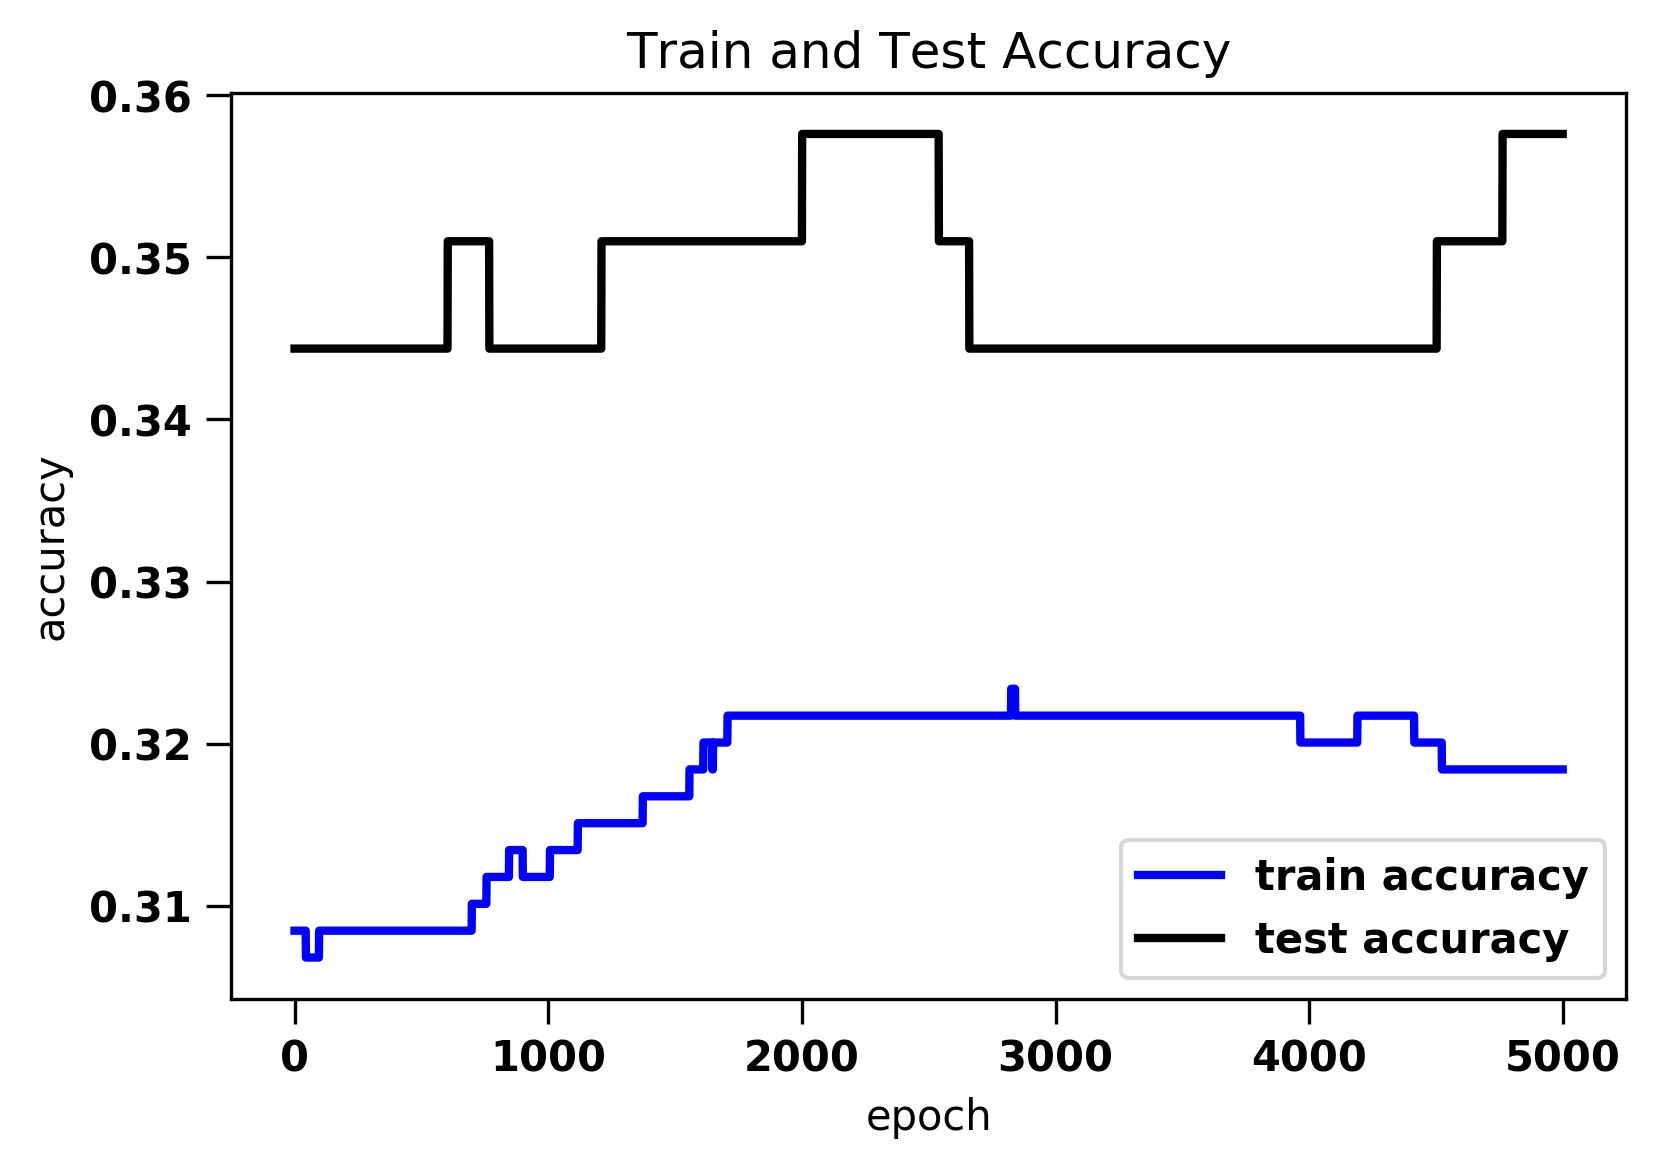

In [218]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [219]:
A_value ,  b_value  =  sess.run ([ A ,  b ])
print(A_value,b_value)

(array([[0.3024176 ],
       [3.7619634 ],
       [0.77504736],
       [1.222871  ]], dtype=float32), array([0.73727185], dtype=float32))


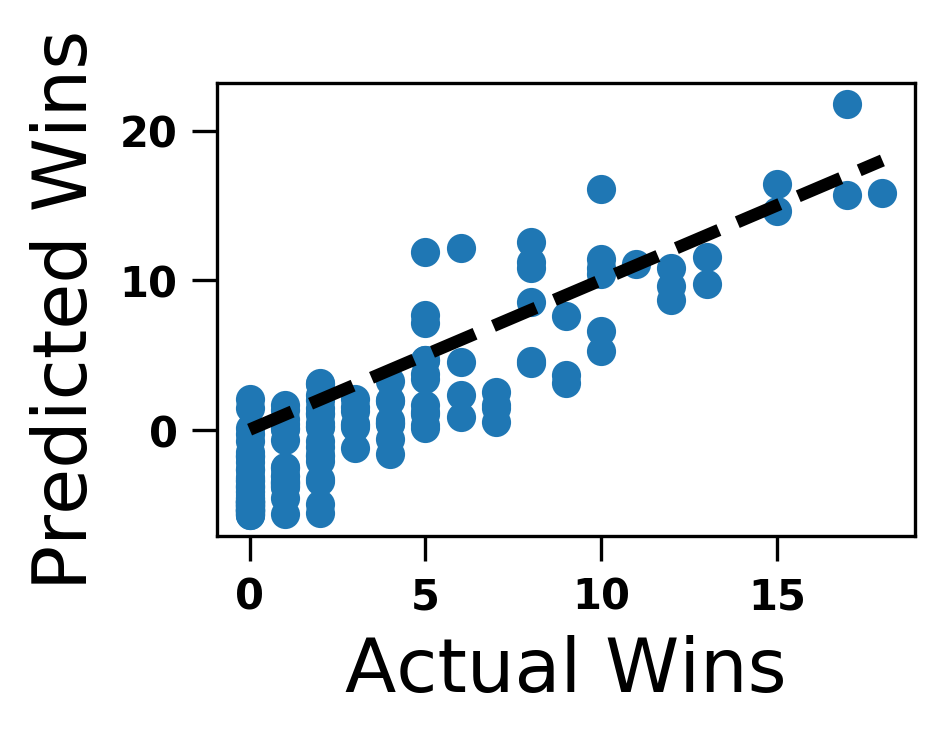

In [220]:
plt.figure(figsize=(3,2))

pred_y = sess.run(mod, feed_dict={data: test_X})

plt.scatter(test_Y,pred_y)
plt.xlabel('Actual Wins',size=18)
plt.ylabel('Predicted Wins',size=18)
plt.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=3)

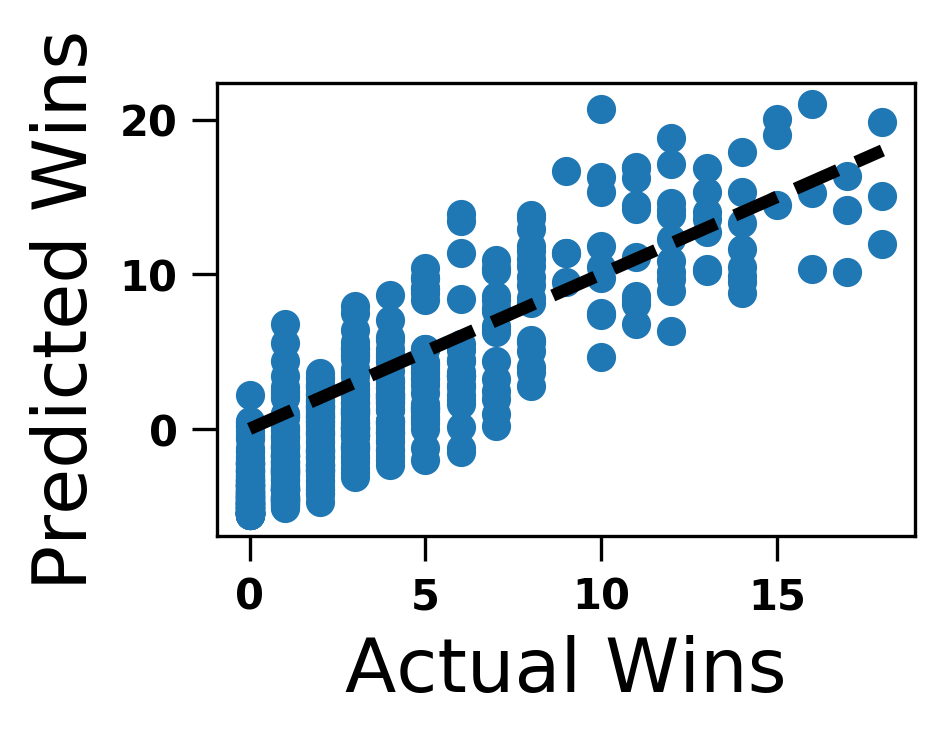

In [221]:
plt.figure(figsize=(3,2))

pred_y = sess.run(mod, feed_dict={data: train_X})

plt.scatter(train_Y,pred_y)
plt.xlabel('Actual Wins',size=18)
plt.ylabel('Predicted Wins',size=18)
plt.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'k--', lw=3)

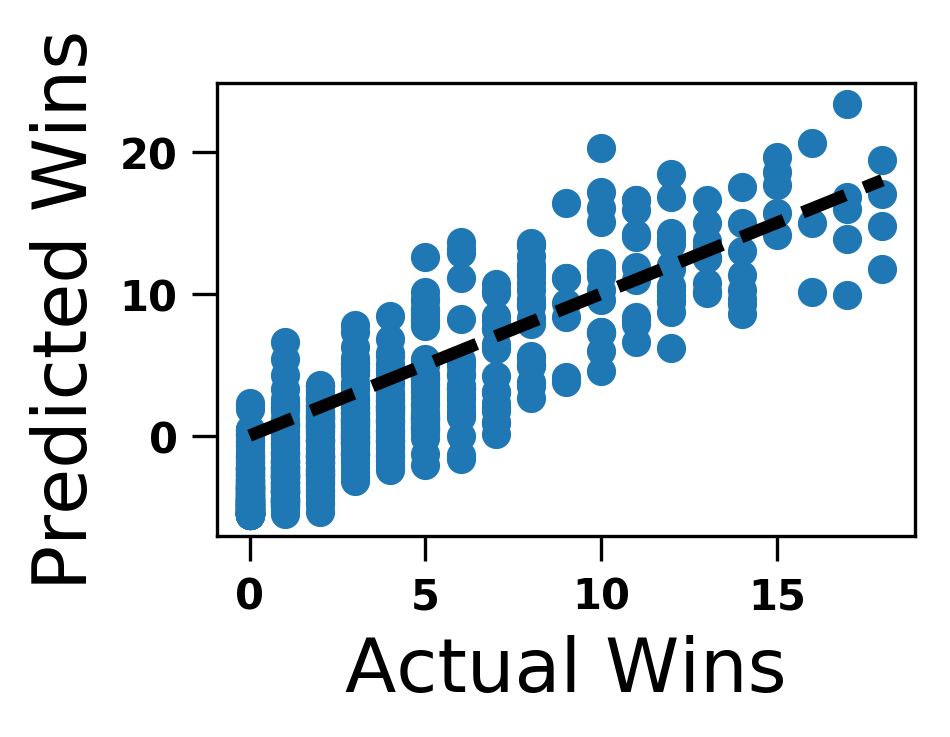

In [222]:
plt.figure(figsize=(3,2))

norm_X = feature_normalize(X)


pred_y = sess.run(mod, feed_dict={data: norm_X})

plt.scatter(Y,pred_y)
plt.xlabel('Actual Wins',size=18)
plt.ylabel('Predicted Wins',size=18)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)

[0.0, 50.0, 0.0, 8.0]

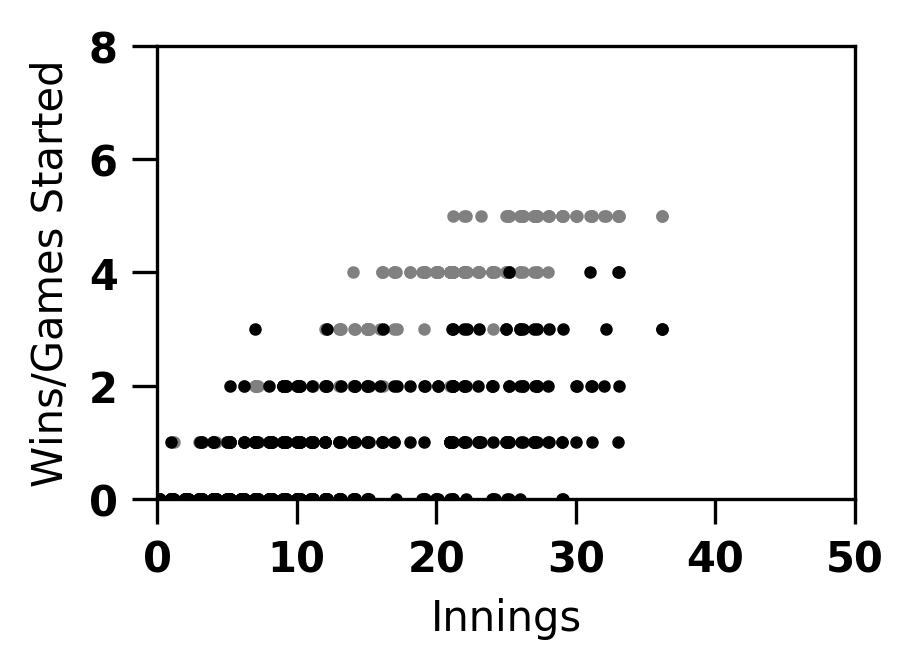

In [223]:
PDict = scrape_saves(year='2018')

plt.figure(figsize=(3,2))
plt.scatter(np.array(PDict.values())[:,1],np.array(PDict.values())[:,2],color='gray',s=4.)
plt.scatter(np.array(PDict.values())[:,1],np.array(PDict.values())[:,0],color='black',s=4.)

plt.xlabel('Innings')
plt.ylabel('Wins/Games Started')
plt.axis([0.,50.,0.0,8.])

In [224]:
X2 = np.array(PDict.values())[:,use_columns]
Y2 = np.array(PDict.values())[:,0]

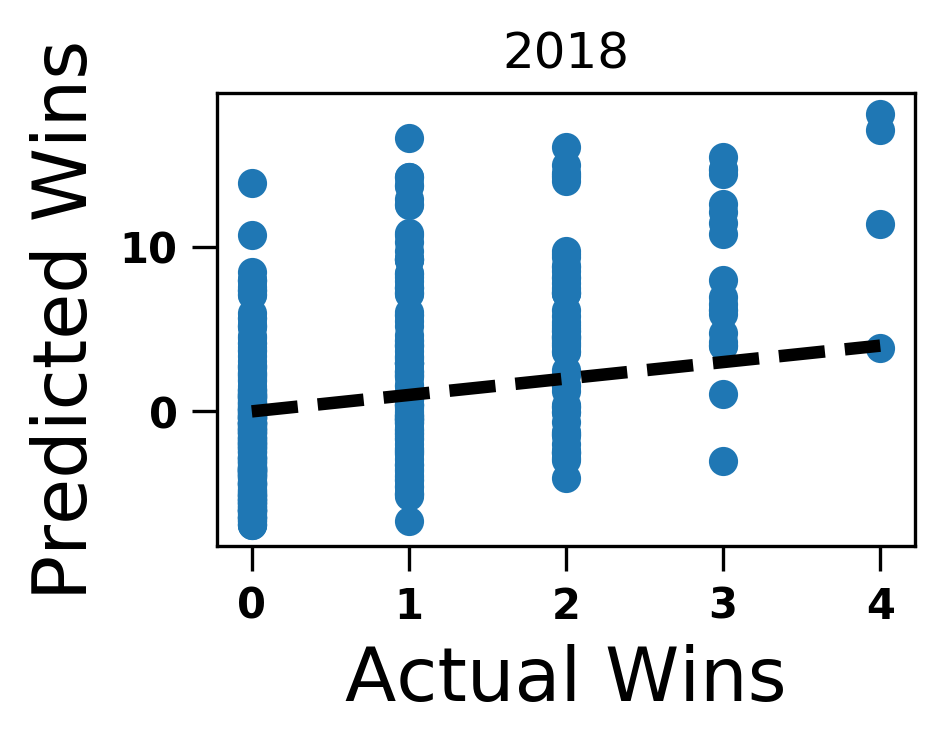

In [225]:
plt.figure(figsize=(3,2))

norm_X2 = feature_normalize(X2)


pred_y = sess.run(mod, feed_dict={data: norm_X2})

plt.scatter(Y2,pred_y)
plt.xlabel('Actual Wins',size=18)
plt.ylabel('Predicted Wins',size=18)
plt.plot([Y2.min(), Y2.max()], [Y2.min(), Y2.max()], 'k--', lw=3)
plt.title('2018')

In [226]:
names = PDict.keys()

for indx,val in enumerate(pred_y):
    if val > 12:
        print np.round(val[0]),names[indx]

15.0 Robbie Ray
14.0 Corey Kluber
13.0 Clayton Kershaw
17.0 Cole Hamels
15.0 Justin Verlander
17.0 Max Scherzer
13.0 Chris Archer
14.0 Jacob deGrom
15.0 Garrett Richards
18.0 Patrick Corbin
14.0 James Paxton
14.0 Dylan Bundy
12.0 Blake Snell
14.0 Chris Sale
13.0 Julio Teheran
14.0 Andrew Cashner
16.0 Stephen Strasburg
15.0 Lance McCullers Jr.
15.0 Gerrit Cole
14.0 Carlos Martinez
13.0 J.A. Happ
14.0 Caleb Smith
14.0 Noah Syndergaard


In [204]:
names = PDict.keys()

for indx,val in enumerate(pred_y):
    if val < 0:
        print np.round(val[0]),names[indx]

-1.0 Chaz Roe
-7.0 Parker Bridwell
-7.0 Roberto Osuna
-3.0 Scott Oberg
-7.0 Matt Belisle
-2.0 Tony Watson
-3.0 Emilio Pagan
-4.0 Brandon Morrow
-6.0 Phil Hughes
-5.0 Drew Pomeranz
-3.0 Matt Andriese
-5.0 Paul Sewald
-3.0 Joe Jimenez
-1.0 Daniel Coulombe
-2.0 Nate Jones
-6.0 Jack Flaherty
-7.0 Jake Thompson
-5.0 Yusmeiro Petit
-0.0 Steve Cishek
-0.0 Kenley Jansen
-5.0 Tim Hill
-2.0 Drew Steckenrider
-1.0 Burch Smith
-5.0 Yoshihisa Hirano
-4.0 Jeff Samardzija
-5.0 Amir Garrett
-8.0 Tony Barnette
-5.0 Daniel Stumpf
-1.0 Peter Moylan
-6.0 Nick Goody
-3.0 Jeremy Hellickson
-4.0 Dominic Leone
-9.0 Felix Pena
-3.0 Chad Green
-4.0 Edgar Santana
-0.0 Bryan Shaw
-8.0 Rex Brothers
-1.0 Domingo German
-6.0 Chris Hatcher
-1.0 Ryan Tepera
-6.0 Josh Smoker
-7.0 Merandy Gonzalez
-4.0 Matt Shoemaker
-1.0 John Axford
-4.0 Joe Smith
-0.0 Mike Fiers
-3.0 Juan Nicasio
-4.0 Brian Flynn
-3.0 Danny Barnes
-3.0 Jeremy Jeffress
-4.0 Danny Farquhar
-3.0 Chris Volstad
-6.0 Hector Rondon
-5.0 Brad Keller
-4.0 Phil